In [1]:
import os,sys
# Change and check directory
os.chdir('C:\WGU\D213\Task2')
os.getcwd()

'C:\\WGU\\D213\\Task2'

In [2]:
# import packages needed
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

In [3]:
# Read in the data
Amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter = '\t', header = None, names=['Reviews', 'Sentiment'])
Yelp = pd.read_csv('yelp_labelled.txt', delimiter = '\t', header = None, names=['Reviews', 'Sentiment'])
df = pd.concat([Amazon, Yelp], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    2000 non-null   object
 1   Sentiment  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [4]:
# Define a regex pattern to detect special characters
pattern = re.compile(r"[^a-zA-Z0-9\s]")  # Matches any character not a-z, A-Z, 0-9, or space
# find and extract special characters from a given text
def extract_special_characters(text):
    special_chars = pattern.findall(text)
    return set(special_chars)
#initialize the set of specaial characters to extract from the reviews
special_chars_set = set()
# Find, print, and remove special characters
for idx, row in df.iterrows():
    text = row["Reviews"]
    special_chars_set |= extract_special_characters(text)
    if special_chars_set:
        row  = re.sub(pattern, "", text)
        df.loc[idx, "Reviews"] = row
    
print(special_chars_set)

{"'", '-', ',', '(', '#', '&', ';', '.', '+', '/', '%', ']', ')', '?', 'ê', '[', ':', '"', '!', 'é', '$', '*'}


In [5]:
# Find and treat duplicate rows 
duplicate_rows = df.duplicated().sum()
print(duplicate_rows)
df = df.drop_duplicates()
# Identify missing values
missing_values = df.isna().sum()
print(missing_values)

19
Reviews      0
Sentiment    0
dtype: int64


In [6]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=None, lower=True, oov_token="<OOV>")
# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['Reviews'].tolist())
# Get the vocabulary size
vocab_size = len(tokenizer.word_index)  # Get the number of unique words
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 3315


In [7]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print(max_sequence_embedding)

8


In [8]:
# Calculate the maximum sequence length
max_sequence_length = df["Reviews"].apply(lambda x: len(x.split())).max()
print("Maximum Sequence Length:", max_sequence_length)

Maximum Sequence Length: 32


In [14]:
# Pad the sequences with the max length 
padded_sequences = pad_sequences(tokenizer.texts_to_sequences(df['Reviews']), maxlen=max_sequence_length, padding='post')
print(padded_sequences[0])

[  27   60    8   56  146   13   70    6  257    7   15   47   15    2
  147  498    4   61  111    5 1392    0    0    0    0    0    0    0
    0    0    0    0]


In [16]:
# Split the data for training and testing
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(np.array(df['Sentiment']))
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_encoded, test_size=0.2, random_state=42)
pd.DataFrame(X_train).to_csv("X_train.csv")
pd.DataFrame(y_train).to_csv("y_train.csv")
pd.DataFrame(X_test).to_csv("X_test.csv")
pd.DataFrame(y_test).to_csv("y_test.csv")
print(len(X_train))
print(len(X_test))

1584
397


In [128]:
# Build the model 
activation = 'sigmoid'
loss = 'binary_crossentropy'
optimizer = 'adam'
num_epochs = 50
early_stopping_monitor = EarlyStopping(monitor='accuracy', patience=2, verbose=1, restore_best_weights=True)
model = Sequential([
    Embedding(vocab_size+1,max_sequence_embedding,input_length=max_sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(50, activation = 'relu'),
    Dense(25, activation = 'relu'),
    Dense(1, activation = activation)  
])
model.compile(loss = loss, optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 32, 8)             26528     
_________________________________________________________________
global_average_pooling1d_17  (None, 8)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 50)                450       
_________________________________________________________________
dense_58 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 26        
Total params: 28,279
Trainable params: 28,279
Non-trainable params: 0
_________________________________________________________________


In [130]:
# Fit the training data to the model 
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor], verbose = True)

Epoch 1/50
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6930 - val_accuracy: 0.4811
Epoch 2/50
50/50 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5423 - val_loss: 0.6908 - val_accuracy: 0.5592
Epoch 3/50
50/50 [==============================] - 0s 868us/step - loss: 0.6854 - accuracy: 0.6282 - val_loss: 0.6789 - val_accuracy: 0.6851
Epoch 4/50
50/50 [==============================] - 0s 830us/step - loss: 0.6458 - accuracy: 0.7607 - val_loss: 0.6230 - val_accuracy: 0.7733
Epoch 5/50
50/50 [==============================] - 0s 810us/step - loss: 0.5156 - accuracy: 0.8655 - val_loss: 0.5153 - val_accuracy: 0.8010
Epoch 6/50
50/50 [==============================] - 0s 809us/step - loss: 0.3393 - accuracy: 0.9141 - val_loss: 0.4447 - val_accuracy: 0.8010
Epoch 7/50
50/50 [==============================] - 0s 817us/step - loss: 0.2160 - accuracy: 0.9457 - val_loss: 0.4227 - val_accuracy: 0.8312
Epoch 8/50

In [132]:
# Test the model for accuracy 
score = model.evaluate(X_train, y_train, verbose=0)
print("Train Loss: " + str(score[0]) + " Train Accuracy: " + str(score[1]))
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: " + str(score[0]) + " Test Accuracy: " + str(score[1]))

Train Loss: 0.016390573233366013 Train Accuracy: 0.9993686676025391
Test Loss: 0.5762823820114136 Test Accuracy: 0.8186398148536682


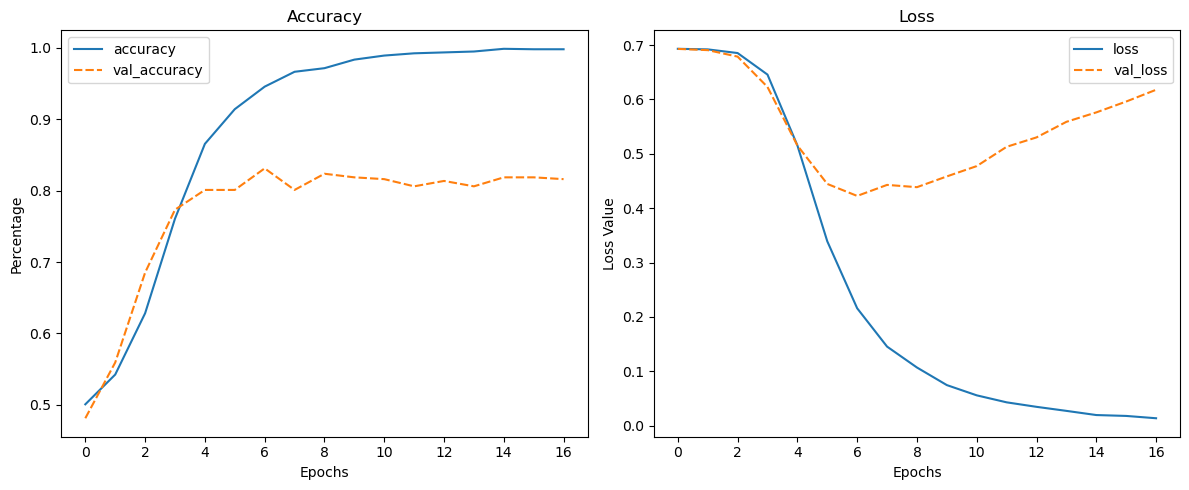

In [134]:
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=axes[0])
sns.lineplot(data=history_df[['loss', 'val_loss']], ax=axes[1])
axes[0].set_title('Accuracy')
axes[1].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[1].set_xlabel('Epochs')
axes[0].set_ylabel('Percentage')
axes[1].set_ylabel('Loss Value')
plt.tight_layout()
plt.show()